In [11]:
#!pip install medmnist

In [15]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import pywt
from torchvision.transforms.functional import to_pil_image
from scipy.stats import skew, kurtosis

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [4]:
data_flag = 'dermamnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 19.7M/19.7M [00:01<00:00, 15.7MB/s]


In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: /home/rodrigo/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoi

In [7]:
# visualization

train_dataset.montage(length=1)

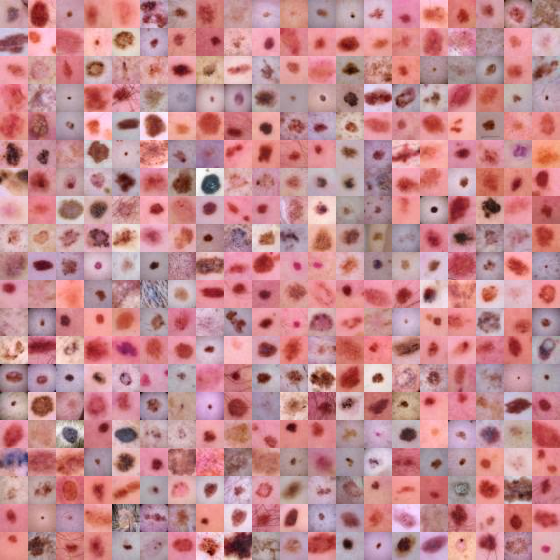

In [8]:
# montage

train_dataset.montage(length=20)

# MLP

### Transform image into vector

#### 1. Flattening and extracting statistical features

In [ ]:
import torch
from scipy.stats import skew, kurtosis

def extract_features(image_tensor):
    """
    Extracts statistical features from a single image tensor.
    Assumes the image has shape (95, 6).
    """
    features = {}

    # Basic statistics
    features['mean'] = torch.mean(image_tensor)
    features['std'] = torch.std(image_tensor)
    features['min'] = torch.min(image_tensor)
    features['max'] = torch.max(image_tensor)

    # Higher-order statistics
    flattened_image = image_tensor.flatten()  # Flatten to 1D for skewness and kurtosis
    features['skewness'] = skew(flattened_image.cpu().numpy())  # Convert to NumPy for skewness
    features['kurtosis'] = kurtosis(flattened_image.cpu().numpy())  # Convert to NumPy for kurtosis

    return torch.tensor(list(features.values()))

# Example: Extract features for the first batch
image_features_list = []
for images, labels in train_loader:
    # Assuming images are already in shape (batch_size, 95, 6)
    image_features = [extract_features(img) for img in images]  # Apply to each image in the batch
    image_features = torch.stack(image_features)  # Stack into a single tensor for use in MLP
    image_features_list.append(image_features)

# Now image_features_list contains the feature tensor for all images
image_features_tensor = torch.cat(image_features_list, dim=0)  # Combine features from all batches
print(image_features_tensor.shape)

#### 2. Wavelet statistical features

In [17]:
def extract_wavelet_features(image_tensor):
    """
    Extracts Discrete Wavelet Transform (DWT) features from an image.
    """
    image = image_tensor.numpy()  # Convert PyTorch tensor to NumPy array
    image = image.squeeze()  # Remove unnecessary dimensions (C, H, W) -> (H, W)
    
    # Perform Single-Level 2D Discrete Wavelet Transform
    LL, (LH, HL, HH) = pywt.dwt2(image, wavelet='haar')

    # LL are the low frequency coefficients (main structural information)
    # LH are the horizontal coefficients (edge information in the horizontal direction)
    # HL are the vertical coefficients (edge information in the vertical direction)
    # HH are the high frequency details (noise information)
    
    # Compute statistical features for each sub-band
    features = []
    for sub_band in [LL, LH, HL, HH]:
        features.extend([
            np.mean(sub_band),  # Mean
            np.std(sub_band),   # Standard deviation
            np.min(sub_band),   # Minimum value
            np.max(sub_band)    # Maximum value
        ])
    
    return np.array(features) # For each image we extract 16 features (4 sub-bands x 4 statistics)

wavelet_features = []
for images, labels in train_loader:
    for img in images:
        wavelet_features.append(extract_wavelet_features(img))

wavelet_features = torch.tensor(wavelet_features, dtype=torch.float32)
print("Feature vector shape:", wavelet_features.shape)

Feature vector shape: torch.Size([7007, 16])


/tmp/ipykernel_98539/517181616.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  wavelet_features = torch.tensor(wavelet_features, dtype=torch.float32)


#### Get the MLPs

In [ ]:
class DNN(nn.Module):

    def __init__(self, input_size, hidden_sizes, num_classes):

        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        if len(hidden_sizes) == 0:
            self.layers.append(nn.Linear(input_size, num_classes))
        else:
            self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
            self.activations.append(nn.ReLU())        
        
            for i in range(len(hidden_sizes)-1):
                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                self.activations.append(nn.ReLU())

            self.layers.append(nn.Linear(hidden_sizes[-1], num_classes))
    
    def forward(self, x):

        for i in range(len(self.activations)):
            x = self.layers[i](x)  # Linear layer
            x = self.activations[i](x)  # Activation function
        
        x = self.layers[-1](x)
        
        return x